In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.preprocessing import text

Parameters

In [2]:
model_path = '../models/tc_model_1_1680891414_tt_1680888903.h5'
dictionary_path = '../data/small_dictionary_1680888160.pickle'
tokenizer_path = '../models/tokenizer_1680888903.pickle'
places_path = '../data/places_krakow_vectorized_1680893122.pickle'

The method that loads model & tokenizer & dictionary

In [3]:
def load(model_path, tokenizer_path, dictionary_path):
    with open(tokenizer_path, 'rb') as file:
        tokenizer = pickle.load(file)
        
    with open(dictionary_path, 'rb') as file:
        dictionary = pickle.load(file)
        dictionary = {value: key for key, value in dictionary.items()}
        
    model = keras.models.load_model(model_path)
    
    return model, tokenizer, dictionary

The method takes model, tokenizer & the input text to calculate the interest vector

In [4]:
def calculate_vector(model, tokenizer, text):
    sequences = tokenizer.texts_to_sequences([text])
    maxlen = model.layers[0].input_length
    x = pad_sequences(sequences, maxlen=maxlen)
    return model.predict(x, verbose=0)[0]

The method that calculates difference between user profile and the places profiles

In [5]:
def mse(vector, place_vector):
    return np.square(vector - place_vector).mean()

The method sorts places by the best fitting ones

In [6]:
def fit_places(vector, places, difference_metric=mse):
    buffer = []
    for place in places:
        buffer.append((place, difference_metric(vector, place[10])))
        
    buffer.sort(key=lambda x: x[1])
    return [b[0] for b in buffer], [b[1] for b in buffer]

### Predict the result on given input text

Set the text for prediction

In [7]:
text = 'I really like eating in bars like that. I would like to drink more beer'

Load model & tokenizer

In [8]:
model, tokenizer, dictionary = load(model_path, tokenizer_path, dictionary_path)

Metal device set to: Apple M1


2023-04-07 20:48:35.076256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 20:48:35.076353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Calculate the result vector

In [9]:
result = calculate_vector(model, tokenizer, text)

2023-04-07 20:48:35.497650: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 20:48:35.721406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 20:48:35.792539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-07 20:48:38.384622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Load places data

In [10]:
with open(places_path, 'rb') as file:
    places = pickle.load(file)

Sort those places by user interests

In [11]:
places_sorted, distances = fit_places(result, places)

### Visualize the result

The method decodes the result vector to human readable form

In [12]:
def visualize_vector(vector, dictionary, text):
    label_weight = [(dictionary[index], weight) for index, weight in enumerate(vector)]
    label_weight.sort(key=lambda x: x[1], reverse=True)
    y, x = zip(*label_weight)
    x = np.array(x)
    x *= 100
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Category')
    plt.xlabel('Weight in %')
    plt.title(f'Result for text "{text}"')

    plt.plot(x, y, 'r.', label='Category weight')
    plt.plot(x, y, 'b', label='Category weight (line)', linewidth=0.5)
    plt.xticks(np.arange(0, 101, 10))
    
    plt.legend()
    plt.show()

The method presents the sorting results

In [16]:
def visualize_places(places_sorted, distances, dictionary, text):
    y = [f'{place[1]} [{dictionary[np.argmax(place[10])]}]' for place in places_sorted]
    x = np.array(distances, dtype='float64')*100
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Place name with best fitting category')
    plt.xlabel('Difference in %')
    plt.title(f'Best fitting places for text "{text}"')

    plt.plot(x, y, 'r.', label='Difference')
    plt.plot(x, y, 'b', label='Difference (line)', linewidth=0.5)
    plt.xticks(np.arange(0, 101, 10))
    
    plt.legend()
    plt.show()

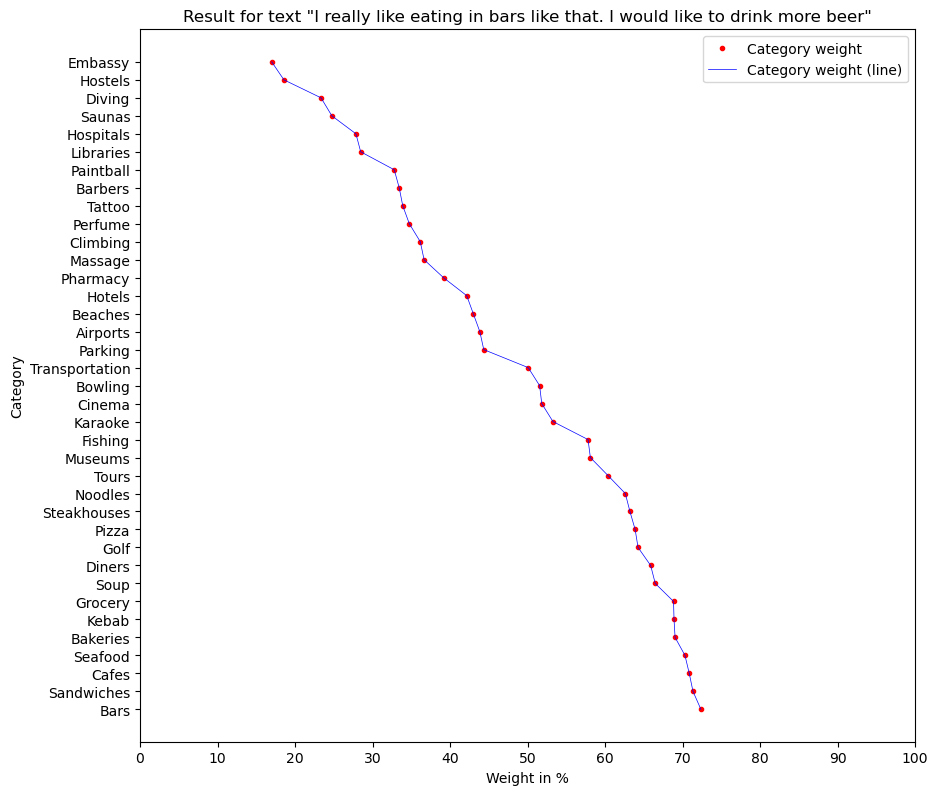

In [14]:
visualize_vector(result, dictionary, text)

In [18]:
visualize_places(places_sorted, distances, dictionary, text)

/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53216 (\N{HANGUL SYLLABLE KU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kamil/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
